# Diffusion as a Stochastic Process

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [804]:
X = np.zeros((102,102))

In [805]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [806]:
X.shape

(102, 102)

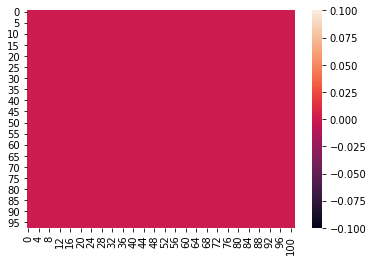

In [807]:
sns.heatmap(X[1:100][1:100])

In [808]:
for i in range(400):
    i,j = np.random.randint(1,101), np.random.randint(1,101)
    X[i][j] = X[i][j] + 1

### Distribucion uniforme

In [809]:
def dist_uni(X):
    for i in range(400):
        i,j = np.random.randint(1,101), np.random.randint(1,101)
        X[i][j] = X[i][j] + 1
    return X

In [810]:
X = dist_uni(X)

In [811]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

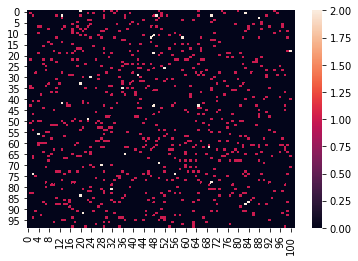

In [812]:
sns.heatmap(X[1:101][1:101])

### Actualización de Condiciones Periódicas

In [813]:
for j in range(1,101):
    X[0][j] = X[100][j]
    X[101][j] = X[1][j]
    X[j][0] = X[j][100]
    X[j][101] = X[j][1]

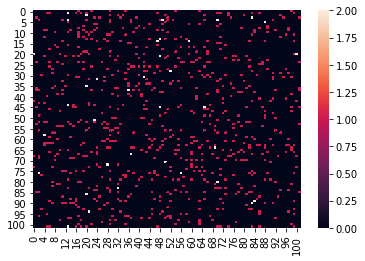

In [814]:
sns.heatmap(X[:][:])

### Ley de Fick

El flujo de partículas es proporcional al gradiente de concentración

$$J(\mathbf{x},t) = - D \nabla c(\mathbf{x}, t)$$

Número de partículas que cruzan, por unidad de área, por unidad de tiempo. Entonces $A J$ es el número de partículas por unidad de tiempo que están atravesando la "ventana" de tamaño $A$.

Para implementar el algoritmo, debemos calcular la probabilidades por unidad de tiempo de moverse las partículas a regiones contiguas. Para ello, usamos una versión discreta de la ley de Fick

$$a(s,d,i,j) =  - A D \frac{\left [X(s,i + 1,j)/L^3 - X(s, i,j)/L^3 \right ]}{L}$$

$$[D] = \frac{L^2}{s}$$

en donde $d$ indica la dirección en la que se movería la partícula, en este caso a la derecha; cada partícula tiene 4 grados de libertad. Esto es, aquí la clave de poder considerar la difusión como un procesos análogo a las reacciones químicas (desde el punto de vista probabilístico), es que cada posibilidad de movimiento es análogo o equivalente a la posibilidad de una transmutación química.


En un espacio de dos dimensiones, hay 4 posibilidades para cada molécula o partícula; hay que ponderarlas todas

In [815]:
D = 1.

In [70]:
a = np.zeros((4,101,101))

### Cálculo de las "propensiones" $a(s,d,i,j)$

In [819]:
for i in range(1,101):
    for j in range(1,101):
        a[0][i][j] = D*(X[i][j] - X[i - 1][j])
        if a[0][i][j] < 0:
            a[0][i][j] = 0
        a[1][i][j] = D*(X[i][j] - X[i + 1][j])
        if a[1][i][j] < 0:
            a[1][i][j] = 0
        a[2][i][j] = D*(X[i][j] - X[i][j - 1])
        if a[2][i][j] < 0:
            a[2][i][j] = 0
        a[3][i][j] = D*(X[i][j] - X[i - 1][j + 1])
        if a[3][i][j] < 0:
            a[3][i][j] = 0

### Rutina Montecarlo para el algoritmo de Gillespie

$$P(\tau, \mu, i, j) = a(\mu, i, j)\, \exp{-[\sum_{\mu i j} a(\mu, i ,j)] \tau ]}$$

$$P(\tau, \mu, i, j) = P_1(\tau) P_2(\mu, i, j| \tau)$$

$$P_1(\tau)= \exp{-[\sum_{\mu i j} a(\mu, i ,j)] \tau ]}  \sum_{\mu i j} a(\mu, i, j)$$

$$P_2(\mu, i, j| \tau) = \frac{a( \mu, i, j)}{\sum_{\mu i j} a(\mu, i, j)}$$

$$P_3(\mu |\tau) = \sum_{i j} P_2(\mu, i, j | \tau) = \frac{\sum_{i j} a( \mu, i, j)}{\sum_{\mu i j} a(\mu, i, j)}$$


$$P_4(i |\tau, \mu) = \sum_{j} P_2(\mu* ,i,j|\tau) = \sum_{j} \left [\frac{a(\mu,i,j)}{\sum_{\mu, i, j} a(\mu,i,j)}   \right ]$$

$$P_5(j |\tau, \mu, i*) = \sum_{i} P_2(\mu*,i*,j|\tau) = \sum_{i} \left [\frac{a(\mu*,i*,j)}{\sum_{\mu, i, j} a(\mu,i,j)}   \right ]$$

In [818]:
P2 = np.zeros((4,101,101))
P3 = np.zeros((4))
P4 = np.zeros((4,101))
P5 = np.zeros((4,101))

In [911]:
def fun_a0(a, d):
    a0 = 0
    for mu in range(0,4):
        for i in range(1,d + 1):
            for j in range(1,d + 1):
                a0 = a0 + a[mu][i][j]
    return a0

In [912]:
fun_a0(a, 100)

230.0

### Función de  actualización de las propoensiones $a(\mu, i, j)$

In [913]:
def actualizacion_as(a, X, d):
    for i in range(1,d + 1):
        for j in range(1,d + 1):
            a[0][i][j] =  D*(X[i][j] - X[i - 1][j])
            if a[0][i][j] < 0:
                a[0][i][j] = 0
            a[1][i][j] =  D*(X[i][j] - X[i + 1][j])
            if a[1][i][j] < 0:
                a[1][i][j] = 0
            a[2][i][j] =  D*(X[i][j] - X[i][j - 1])
            if a[2][i][j] < 0:
                a[2][i][j] = 0
            a[3][i][j] =  D*(X[i][j] - X[i][j + 1])
            if a[3][i][j] < 0:
                a[3][i][j] = 0
    return a

In [566]:
for mu in range(4):
    for i in range(1,101):
        for j in range(1,101):
            P2[mu][i][j] = a[d][i][j]/a0

In [92]:
for mu in range(4):
    suma_mu = 0
    for i in range(1,101):
        for j in range(1,101):
            suma_mu = suma_mu + P2[mu][i][j]
    P3[mu] = suma_mu

In [96]:
for mu in range(4):
    for i in range(1,101):
        suma_j = 0
        for j in range(1,101):
            suma_j = suma_j + P2[mu,i,j]
        P4[mu][i] = suma_j

In [97]:
for mu in range(4):
    for j in range(1,101):
        suma_i = 0
        for i in range(1,101):
            suma_i = suma_i + P2[mu,i,j]
        P5[mu][j] = suma_i

### Función que actualiza las probabilidades

## Aquí está el problema...

**Las probabilidades $P_4$ y $P_5$ no pueden calcularse hasta que ya se han definido $\mu$ e $i$ respectivamente**

In [989]:
def act_probs(a, a0, P2, P3, d):

    for mu in range(4):
        for i in range(1,d + 1):
            for j in range(1,d + 1):
                P2[mu][i][j] = a[mu][i][j]/a0
                
    for mu in range(4):
        suma_mu = 0
        for i in range(1,d + 1):
            for j in range(1,d + 1):
                suma_mu = suma_mu + P2[mu][i][j]
        P3[mu] = suma_mu
        
#    for mu in range(4):
#        for i in range(1,d + 1):
#            suma_j = 0
#            for j in range(1,d + 1):
#                suma_j = suma_j + P2[mu,i,j]
#            P4[mu][i] = suma_j
            
#    for mu in range(4):
#        for j in range(1,d + 1):
#            suma_i = 0
#            for i in range(1,d + 1):
#                suma_i = suma_i + P2[mu,i,j]
#            P5[mu][j] = suma_i
            
    return P2, P3

### Algoritmo de Gillespie generalizado a ambientes anisotrópicos

$$\tau = \frac{1}{a_0} \ln{\left (\frac{1}{r1}\right )}$$

$$\sum_{\nu=1}^{\mu -1} P_3(\nu|\tau) < r2 \le \sum_{\nu=1}^{\mu} P_3(\nu|\tau)$$


$$\sum_{i=1}^{i* -1} P_4(\nu, i|\tau) < r3*P_3(\mu |\tau) \le \sum_{i = 1}^{i*} P_3(\mu, i|\tau)$$


$$\sum_{j=1}^{j* -1} P_5(\nu, j|\tau) < r4*P_4(i |\tau, \mu) \le \sum_{j = 1}^{j*} P_5(\mu, j|\tau)$$

Tenemos que elegir un cuarteto de números $\tau$, el intervalo de tiempo, $\mu$ el procesos (reacción-difusión), $i$ el renglón en la mala y $j$ la columna en la malla.

### Funciones del algoritmo de Gillespie que generan el cuarteto de números para actualizar

In [992]:
def fun_mu(P3,r2):
    suma_mu = 0.
    for nu in range(4):
        #print('P3[mu]', P3[nu],'nu',nu)
        suma_mu = suma_mu + P3[nu]
        #print('Suma_mu', suma_mu,'r2',r2)
        if suma_mu >= r2:
            return nu
    return nu

In [993]:
def fun_i(P3,P4,r3,mu):
    suma_i = 0
    for i_star in range(1,101):
        suma_i = suma_i + P4[i_star]
        if suma_i >= r3*P3[mu]:
            return i_star
    return i_star

In [994]:
def fun_j(P4,r4,mu,i):
    suma_j = 0.
    for j_star in range(1,101):
        suma_j = suma_j + P2[mu][i][j_star]
        if suma_j >= r4*(P4[i]):
            return j_star
    return j_star

In [885]:
chosen_mus = [fun_mu(P3,np.random.rand()) for n in range(1000)]

Text(0.5, 1.0, "Distribución de las mu's")

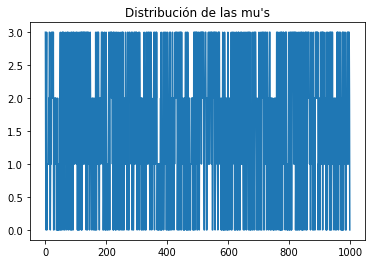

In [886]:
plt.plot(chosen_mus)
plt.title("Distribución de las mu's")

Text(0.5, 1.0, "Distribución de las i's")

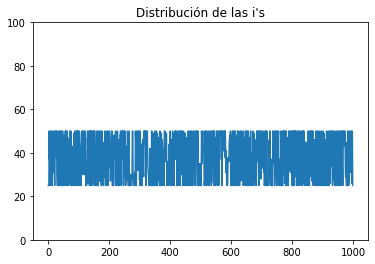

In [889]:
plt.plot([fun_i(P3,P4,np.random.rand(),fun_mu(P3,np.random.rand())) for i in range(1000)])
plt.ylim(0,100)
plt.title("Distribución de las i's")

Text(0.5, 1.0, "Distribución de las j's")

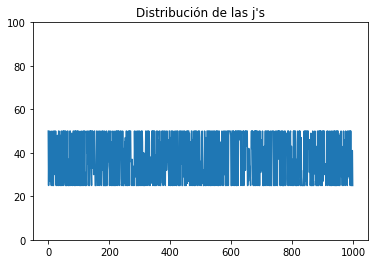

In [890]:
plt.plot([fun_j(P3,P5,np.random.rand(),fun_mu(P3,np.random.rand())) for i in range(1000)])
plt.ylim(0,100)
plt.title("Distribución de las j's")

### Actualizacion de la matriz de concentracion

In [978]:
def fun_act_dif(X, mu, i, j):
    if mu == 0:
        X[i,j] = X[i,j] - 1
        X[i - 1,j] = X[i - 1,j] + 1
    # Difusion hacia abajo    
    elif mu == 1:
        X[i,j] = X[i,j] - 1
        X[i + 1,j] = X[i + 1,j] + 1
    # Difusion hacia la izquierda
    elif mu == 2:
        X[i,j] = X[i,j] - 1
        X[i,j - 1] = X[i,j - 1] + 1
    # Difusion hacia la derecha
    elif mu == 3:
        X[i,j] = X[i,j] - 1
        X[i,j + 1] = X[i,j + 1] + 1
    return X

In [1000]:
def paso_montecarlo(X, a, t, P2, P3, d):
    
    r1 = np.random.rand()
    r2 = np.random.rand()
    r3 = np.random.rand()
    r4 = np.random.rand()
    
    
    # Calculo del peso universal a0
    
    a0 = fun_a0(a, d)
    
    #Calculo del intervalo tau
    
    
    tau = (1./a0)*np.log(1/r1)
    
    #Actualizamos el tiempo
                
    t = t + tau
    
    
    # Seleccion del procesos de reaccion-difusion
    
    mu = fun_mu(P3,r2)
    
        # Aqui se tienen que calcular las probabilidades P4 y P5
    
    for i in range(1,d + 1):
        suma_j = 0
        for j in range(1,d + 1):
            suma_j = suma_j + P2[mu,i,j]
        P4[i] = suma_j
        
    # Seleccion del renglon de ocurrencia
        
    i = fun_i(P3,P4,r3,mu)
    
    
    
    # Seleccion de la columna de ocurrencia
    
    j = fun_j(P4,r4,mu,i)
    
    print('tau',format(tau, '.4f'),'mu',mu,'i',i,'j',j)
    
    print('X[i,j]',X[i][j], 'X[i - 1,j]',X[i - 1][j], 'X[i + 1,j]',X[i + 1][j],#
          'X[i,j - 1]',X[i][j - 1], 'X[i,j + 1]',X[i][j + 1], 'a(mu,i,j)',a[mu][i][j],#
          'P2[mu][i][j]',P2[mu][i][j],'P3[mu]',P3[mu], 'P4[mu][i]',P4[i])
    
    # Actualizamos el vector de concentracion de acuerdo con el proceso elegido

    X = fun_act_dif(X, mu, i, j)
    
    print('X[i,j]',X[i][j])
    
    # Actualizamos las condiciones de contorno si se actualizo algun punto de la frontera
    
    if i == 1 | i == 100 | j == 1 | j == 100:
        X = func_act_CC(X)

        
    # Actualizamos las as de acuerdo al nuevo vector X de concentracion
    
    a = actualizacion_as(a, X, d)
    
    # Actualizamos el peso universal a0
    
    a0 = fun_a0(a, d)
    
    
    # Actualizamos las Ps
    
    P2, P3 = act_probs(a,a0,P2,P3, d)
    

    
    return t, X, a, P2, P3

### Tests

In [963]:
X0 = np.zeros((102,102))

In [964]:
X0

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [965]:
for i in range(25,51):
    for j in range(25,51):
        X0[i][j] = 40

In [966]:
def func_act_CC(X0, d):
    for j in range(1,d + 1):
        X0[0][j] = X0[d][j]
        X0[d + 1][j] = X0[1][j]
        X0[j][0] = X0[j][d]
        X0[j][d + 1] = X0[j][1]
    return X0

In [967]:
X0 = func_act_CC(X0, 100)

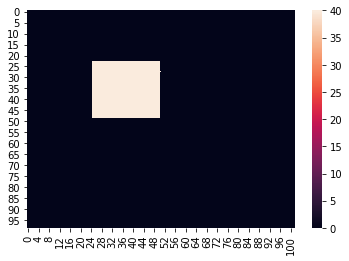

In [968]:
sns.heatmap(X0[1:101][1:101])

In [970]:
X0.shape

(102, 102)

In [923]:
a = np.zeros((4,102,102))

In [924]:
def actualizacion_as(a, X, d):
    for i in range(1,d + 1):
        for j in range(1,d + 1):
            a[0][i][j] =  D*(X[i][j] - X[i - 1][j])
            if a[0][i][j] < 0:
                a[0][i][j] = 0
            a[1][i][j] =  D*(X[i][j] - X[i + 1][j])
            if a[1][i][j] < 0:
                a[1][i][j] = 0
            a[2][i][j] =  D*(X[i][j] - X[i][j - 1])
            if a[2][i][j] < 0:
                a[2][i][j] = 0
            a[3][i][j] =  D*(X[i][j] - X[i][j + 1])
            if a[3][i][j] < 0:
                a[3][i][j] = 0
    return a

In [925]:
a = actualizacion_as(a,X0, 100)

In [926]:
a0 = fun_a0(a, 100)

In [927]:
P2 = np.zeros((4,102,102))
P3 = np.zeros((4))
P4 = np.zeros((4,102))
P5 = np.zeros((4,102))

In [930]:
P2, P3, P4, P5 = act_probs(a,a0,P2,P3,P4,P5,100)

In [931]:
P3

array([0.25, 0.25, 0.25, 0.25])

In [863]:
r1 = np.random.rand()
r2 = np.random.rand()
r3 = np.random.rand()
r4 = np.random.rand()

mu = fun_mu(P3,r2)
    
#Calculo del renglon

i = fun_i(P3,P4,r3,mu)

#Calculo de la columna

j = fun_j(P3,P5,r4,mu)

In [864]:
mu,i,j

(0, 25, 33)

#### Está mal actualizada $P_3(\mu|\tau)$ porque $a(\mu,i,j)$ no estaba operando bien

In [932]:
for i in range(20,56):
    print(P2[3][i][50])

0.0
0.0
0.0
0.0
0.0
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.0
0.0
0.0
0.0
0.0


#### Is it $a(\mu,i,j)$ well calculated?

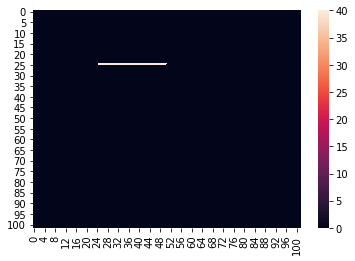

In [933]:
sns.heatmap(a[0][:][:])

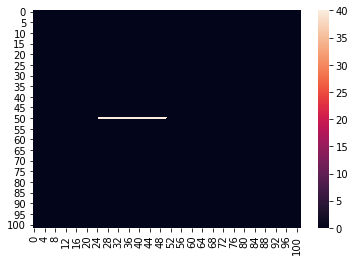

In [934]:
sns.heatmap(a[1][:][:])

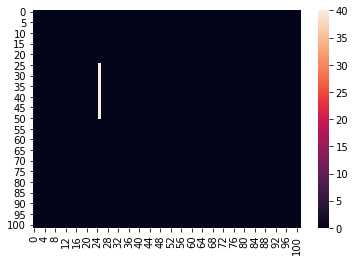

In [935]:
sns.heatmap(a[2][:][:])

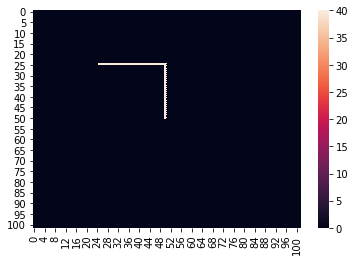

In [443]:
sns.heatmap(a[3][:][:])

#### Is not!!!

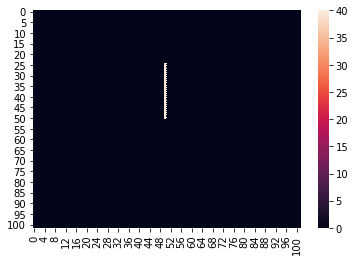

In [936]:
sns.heatmap(a[3][:][:])

In [937]:
P2[0][25][26]

0.009615384615384616

#### $P_2(\mu | \tau)$ is well calculated...is it!?

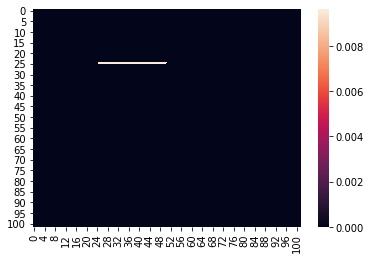

In [938]:
sns.heatmap(P2[0][:][:])

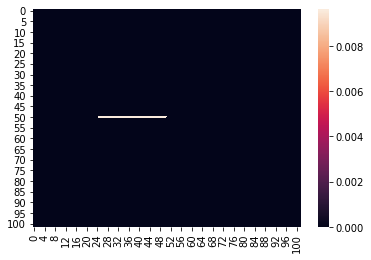

In [939]:
sns.heatmap(P2[1][:][:])

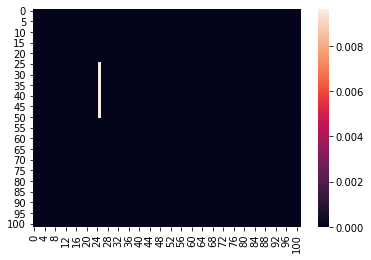

In [940]:
sns.heatmap(P2[2][:][:])

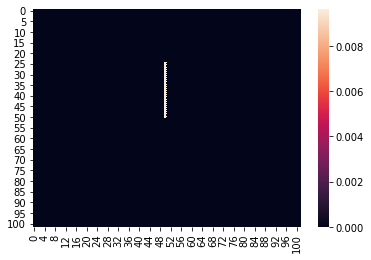

In [941]:
sns.heatmap(P2[3][:][:])

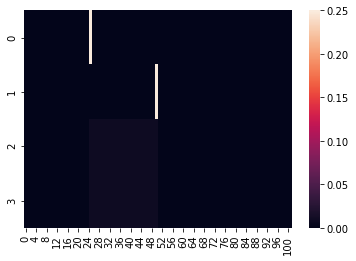

In [942]:
sns.heatmap(P4)

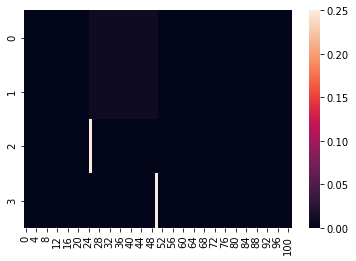

In [943]:
sns.heatmap(P5)

In [794]:
import time

In [791]:
X0 = X

## Simulación

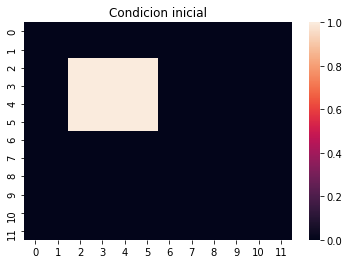

tau 0.0074 mu 3 i 4 j 5
X[i,j] 1.0 X[i - 1,j] 1.0 X[i + 1,j] 1.0 X[i,j - 1] 1.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.0002403846153846154 P3[mu] 0.0009615384615384616 P4[mu][i] 0.0002403846153846154
X[i,j] 0.0


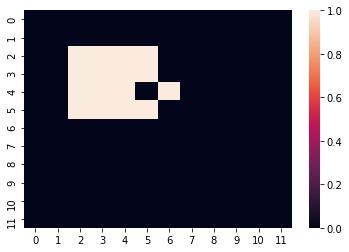

tau 0.0377 mu 1 i 5 j 5
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 1.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.045454545454545456 P3[mu] 0.27272727272727276 P4[mu][i] 0.18181818181818182
X[i,j] 0.0


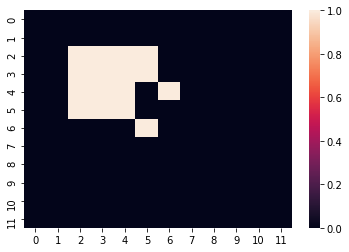

tau 0.0391 mu 1 i 6 j 5
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.041666666666666664 P3[mu] 0.24999999999999997 P4[mu][i] 0.041666666666666664
X[i,j] 0.0


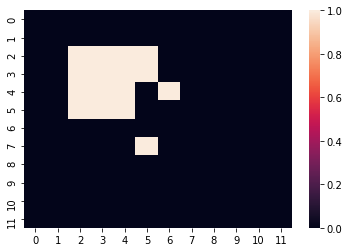

tau 0.0230 mu 1 i 5 j 2
X[i,j] 1.0 X[i - 1,j] 1.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 1.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.041666666666666664 P3[mu] 0.24999999999999997 P4[mu][i] 0.125
X[i,j] 0.0


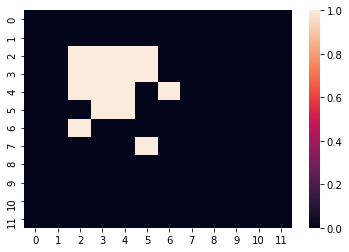

tau 0.0396 mu 2 i 3 j 2
X[i,j] 1.0 X[i - 1,j] 1.0 X[i + 1,j] 1.0 X[i,j - 1] 0.0 X[i,j + 1] 1.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.03571428571428571 P3[mu] 0.24999999999999994 P4[mu][i] 0.03571428571428571
X[i,j] 0.0


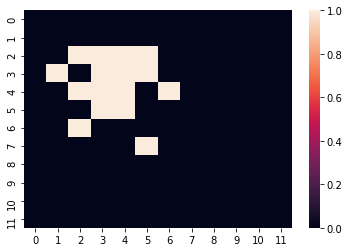

tau 0.0014 mu 2 i 3 j 1
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.029411764705882353 P3[mu] 0.23529411764705885 P4[mu][i] 0.058823529411764705
X[i,j] 0.0


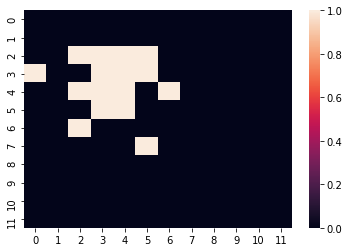

tau 0.0354 mu 1 i 2 j 2
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 1.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.03333333333333333 P3[mu] 0.26666666666666666 P4[mu][i] 0.03333333333333333
X[i,j] 0.0


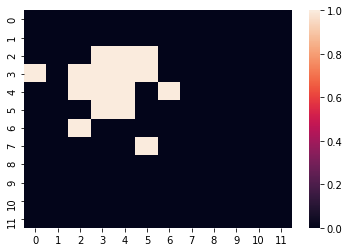

tau 0.0257 mu 3 i 4 j 6
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.03571428571428571 P3[mu] 0.24999999999999994 P4[mu][i] 0.07142857142857142
X[i,j] 0.0


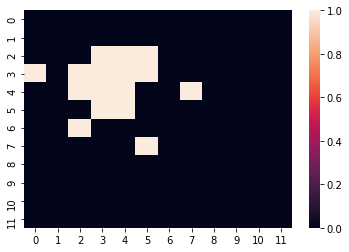

tau 0.0001 mu 1 i 3 j 5
X[i,j] 1.0 X[i - 1,j] 1.0 X[i + 1,j] 0.0 X[i,j - 1] 1.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.03571428571428571 P3[mu] 0.24999999999999994 P4[mu][i] 0.03571428571428571
X[i,j] 0.0


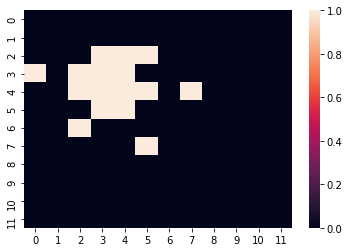

tau 0.0236 mu 3 i 4 j 5
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 1.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.03333333333333333 P3[mu] 0.2333333333333333 P4[mu][i] 0.06666666666666667
X[i,j] 0.0


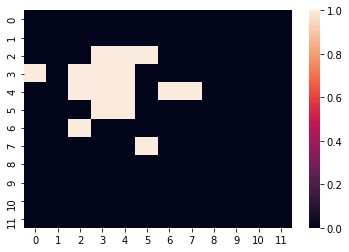

tau 0.0143 mu 0 i 2 j 5
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 1.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.03333333333333333 P3[mu] 0.26666666666666666 P4[mu][i] 0.1
X[i,j] 0.0


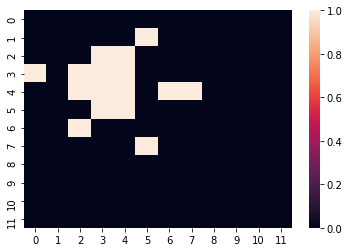

tau 0.0057 mu 1 i 6 j 2
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.03125 P3[mu] 0.25 P4[mu][i] 0.03125
X[i,j] 0.0


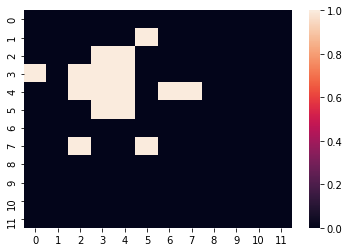

tau 0.0014 mu 1 i 4 j 2
X[i,j] 1.0 X[i - 1,j] 1.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 1.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.03125 P3[mu] 0.25 P4[mu][i] 0.09375
X[i,j] 0.0


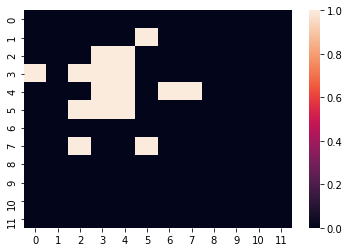

tau 0.0152 mu 1 i 7 j 5
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.029411764705882353 P3[mu] 0.2647058823529412 P4[mu][i] 0.058823529411764705
X[i,j] 0.0


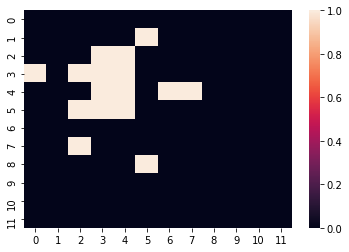

tau 0.0108 mu 3 i 5 j 4
X[i,j] 1.0 X[i - 1,j] 1.0 X[i + 1,j] 0.0 X[i,j - 1] 1.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.029411764705882353 P3[mu] 0.23529411764705885 P4[mu][i] 0.029411764705882353
X[i,j] 0.0


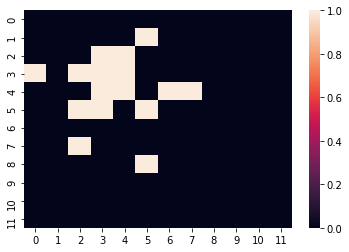

tau 0.0357 mu 2 i 8 j 5
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02631578947368421 P3[mu] 0.23684210526315788 P4[mu][i] 0.02631578947368421
X[i,j] 0.0


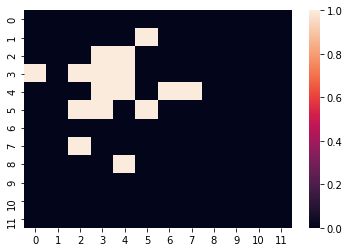

tau 0.0168 mu 0 i 2 j 3
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 1.0 X[i,j - 1] 0.0 X[i,j + 1] 1.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02631578947368421 P3[mu] 0.2631578947368421 P4[mu][i] 0.05263157894736842
X[i,j] 0.0


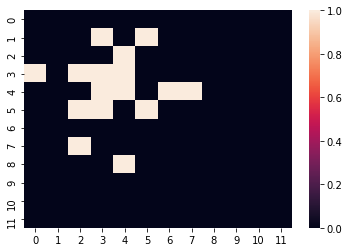

tau 0.0395 mu 0 i 7 j 2
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.023809523809523808 P3[mu] 0.26190476190476186 P4[mu][i] 0.023809523809523808
X[i,j] 0.0


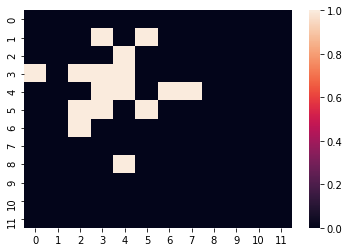

tau 0.0015 mu 0 i 5 j 5
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.025 P3[mu] 0.24999999999999997 P4[mu][i] 0.05
X[i,j] 0.0


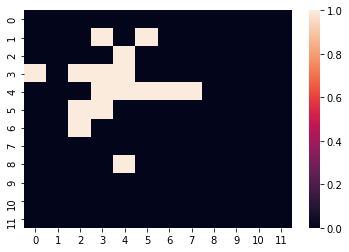

tau 0.0068 mu 3 i 8 j 4
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.027777777777777776 P3[mu] 0.22222222222222227 P4[mu][i] 0.027777777777777776
X[i,j] 0.0


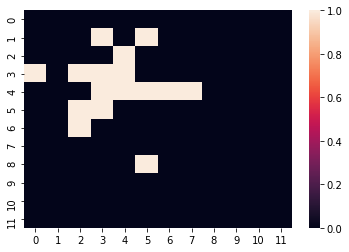

tau 0.0029 mu 2 i 5 j 2
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 1.0 X[i,j - 1] 0.0 X[i,j + 1] 1.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.027777777777777776 P3[mu] 0.22222222222222227 P4[mu][i] 0.027777777777777776
X[i,j] 0.0


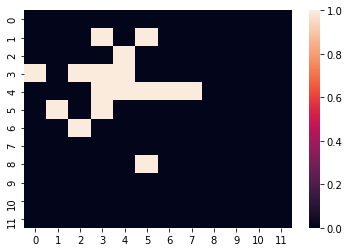

tau 0.0097 mu 0 i 3 j 2
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 1.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.025 P3[mu] 0.27499999999999997 P4[mu][i] 0.05
X[i,j] 0.0


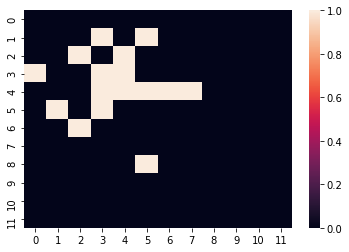

tau 0.0153 mu 0 i 5 j 1
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.023809523809523808 P3[mu] 0.26190476190476186 P4[mu][i] 0.023809523809523808
X[i,j] 0.0


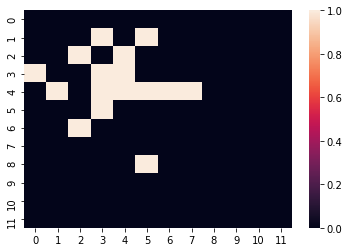

tau 0.0073 mu 1 i 1 j 5
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.023809523809523808 P3[mu] 0.26190476190476186 P4[mu][i] 0.047619047619047616
X[i,j] 0.0


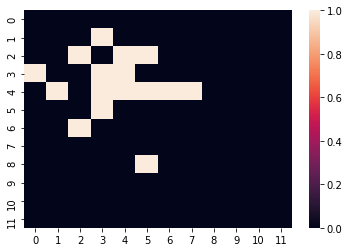

tau 0.0104 mu 2 i 2 j 2
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.025 P3[mu] 0.22499999999999998 P4[mu][i] 0.05
X[i,j] 0.0


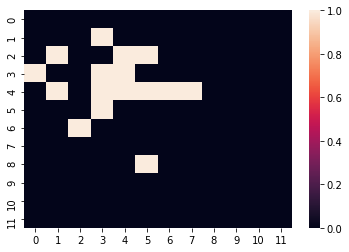

tau 0.0013 mu 2 i 4 j 3
X[i,j] 1.0 X[i - 1,j] 1.0 X[i + 1,j] 1.0 X[i,j - 1] 0.0 X[i,j + 1] 1.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.025 P3[mu] 0.22499999999999998 P4[mu][i] 0.05
X[i,j] 0.0


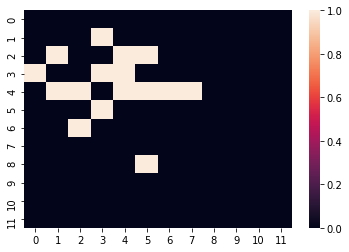

tau 0.0957 mu 2 i 8 j 5
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.022727272727272728 P3[mu] 0.20454545454545459 P4[mu][i] 0.022727272727272728
X[i,j] 0.0


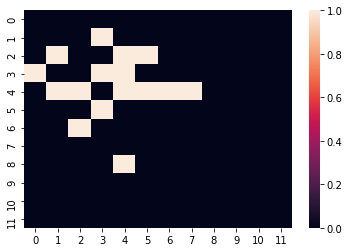

tau 0.0200 mu 2 i 6 j 2
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.022727272727272728 P3[mu] 0.20454545454545459 P4[mu][i] 0.022727272727272728
X[i,j] 0.0


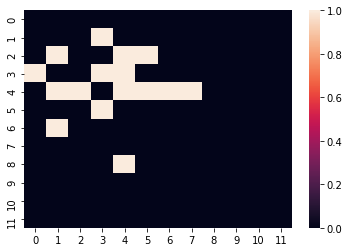

tau 0.0312 mu 2 i 3 j 3
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 1.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.022727272727272728 P3[mu] 0.20454545454545459 P4[mu][i] 0.022727272727272728
X[i,j] 0.0


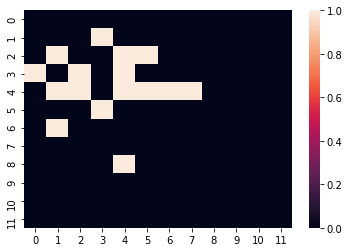

tau 0.0057 mu 3 i 4 j 2
X[i,j] 1.0 X[i - 1,j] 1.0 X[i + 1,j] 0.0 X[i,j - 1] 1.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.022727272727272728 P3[mu] 0.22727272727272732 P4[mu][i] 0.045454545454545456
X[i,j] 0.0


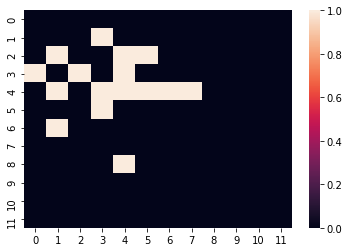

tau 0.0022 mu 3 i 6 j 1
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.022727272727272728 P3[mu] 0.22727272727272732 P4[mu][i] 0.022727272727272728
X[i,j] 0.0


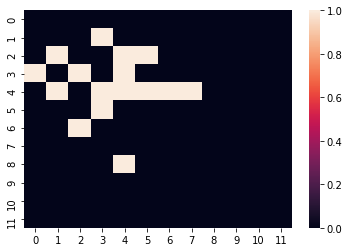

tau 0.0218 mu 0 i 3 j 2
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.022727272727272728 P3[mu] 0.27272727272727276 P4[mu][i] 0.022727272727272728
X[i,j] 0.0


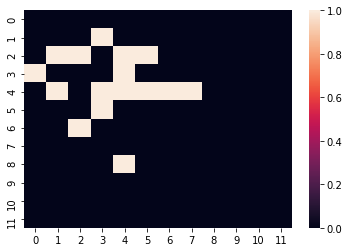

tau 0.0075 mu 3 i 1 j 3
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.023809523809523808 P3[mu] 0.21428571428571427 P4[mu][i] 0.023809523809523808
X[i,j] 0.0


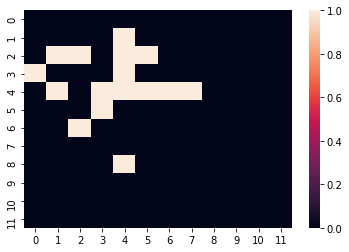

tau 0.0990 mu 3 i 3 j 4
X[i,j] 1.0 X[i - 1,j] 1.0 X[i + 1,j] 1.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.025 P3[mu] 0.22499999999999998 P4[mu][i] 0.025
X[i,j] 0.0


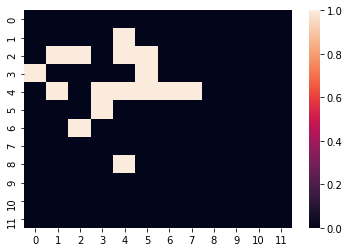

tau 0.0172 mu 1 i 8 j 4
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.025 P3[mu] 0.27499999999999997 P4[mu][i] 0.025
X[i,j] 0.0


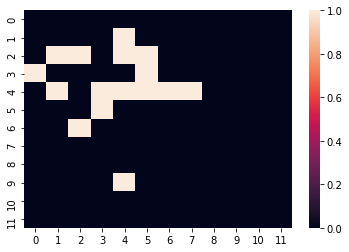

tau 0.0111 mu 0 i 2 j 1
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 1.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.025 P3[mu] 0.27499999999999997 P4[mu][i] 0.07500000000000001
X[i,j] 0.0


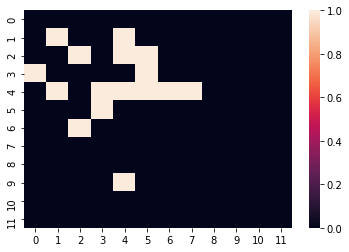

tau 0.0444 mu 1 i 4 j 7
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 1.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.023809523809523808 P3[mu] 0.26190476190476186 P4[mu][i] 0.11904761904761904
X[i,j] 0.0


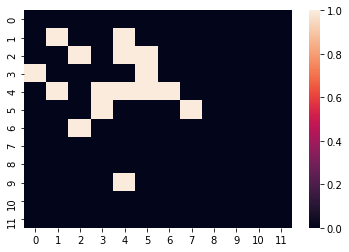

tau 0.0153 mu 1 i 2 j 2
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.022727272727272728 P3[mu] 0.25000000000000006 P4[mu][i] 0.045454545454545456
X[i,j] 0.0


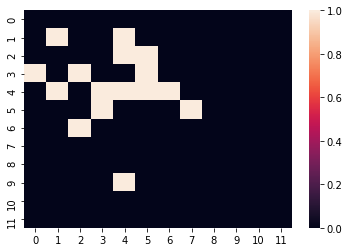

tau 0.0752 mu 2 i 6 j 2
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.022727272727272728 P3[mu] 0.25000000000000006 P4[mu][i] 0.022727272727272728
X[i,j] 0.0


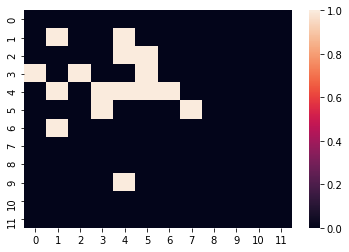

tau 0.0054 mu 3 i 3 j 2
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.022727272727272728 P3[mu] 0.25000000000000006 P4[mu][i] 0.045454545454545456
X[i,j] 0.0


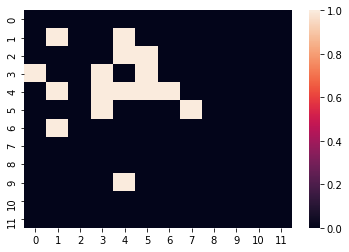

tau 0.0051 mu 3 i 9 j 4
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.023809523809523808 P3[mu] 0.26190476190476186 P4[mu][i] 0.023809523809523808
X[i,j] 0.0


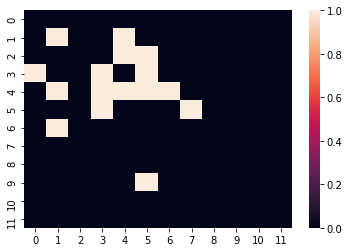

tau 0.0082 mu 3 i 4 j 6
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 1.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.023809523809523808 P3[mu] 0.26190476190476186 P4[mu][i] 0.047619047619047616
X[i,j] 0.0


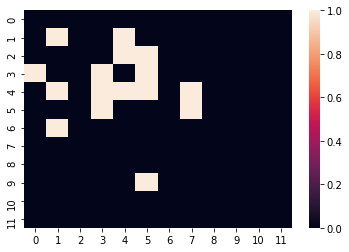

tau 0.1088 mu 0 i 1 j 1
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.023809523809523808 P3[mu] 0.21428571428571427 P4[mu][i] 0.047619047619047616
X[i,j] 0.0


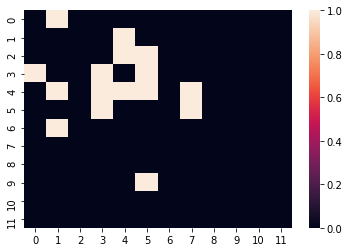

tau 0.0193 mu 1 i 6 j 1
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02631578947368421 P3[mu] 0.21052631578947367 P4[mu][i] 0.02631578947368421
X[i,j] 0.0


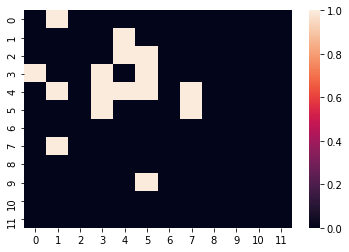

tau 0.0183 mu 3 i 7 j 1
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02631578947368421 P3[mu] 0.2894736842105263 P4[mu][i] 0.02631578947368421
X[i,j] 0.0


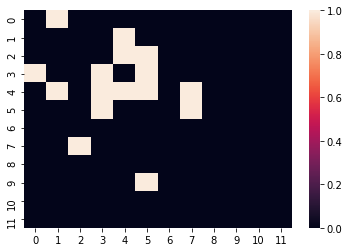

tau 0.0053 mu 1 i 4 j 5
X[i,j] 1.0 X[i - 1,j] 1.0 X[i + 1,j] 0.0 X[i,j - 1] 1.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02631578947368421 P3[mu] 0.21052631578947367 P4[mu][i] 0.07894736842105263
X[i,j] 0.0


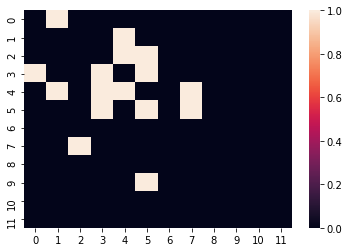

tau 0.0405 mu 3 i 1 j 4
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 1.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.023809523809523808 P3[mu] 0.2857142857142857 P4[mu][i] 0.023809523809523808
X[i,j] 0.0


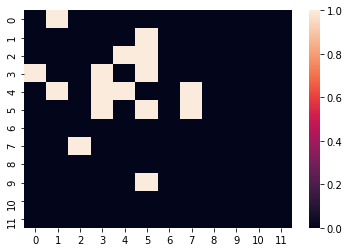

tau 0.0484 mu 1 i 5 j 5
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.023809523809523808 P3[mu] 0.21428571428571427 P4[mu][i] 0.07142857142857142
X[i,j] 0.0


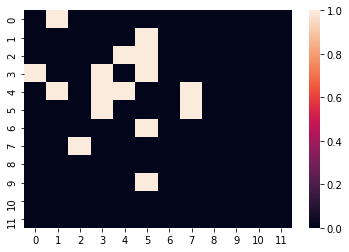

tau 0.0066 mu 3 i 4 j 7
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 1.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.023809523809523808 P3[mu] 0.2857142857142857 P4[mu][i] 0.07142857142857142
X[i,j] 0.0


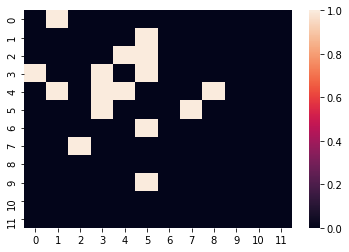

tau 0.0131 mu 1 i 6 j 5
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.022727272727272728 P3[mu] 0.22727272727272732 P4[mu][i] 0.022727272727272728
X[i,j] 0.0


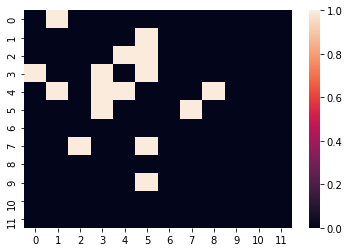

tau 0.0005 mu 2 i 4 j 8
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.022727272727272728 P3[mu] 0.27272727272727276 P4[mu][i] 0.06818181818181818
X[i,j] 0.0


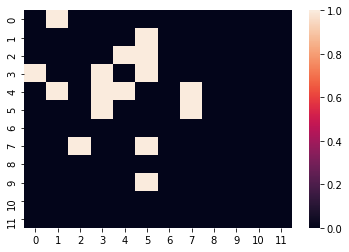

tau 0.0171 mu 1 i 7 j 2
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.023809523809523808 P3[mu] 0.21428571428571427 P4[mu][i] 0.047619047619047616
X[i,j] 0.0


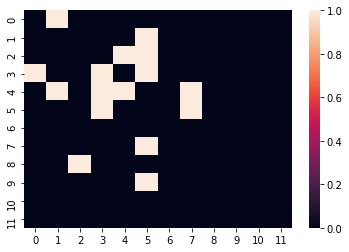

tau 0.0206 mu 0 i 1 j 5
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 1.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.023809523809523808 P3[mu] 0.21428571428571427 P4[mu][i] 0.023809523809523808
X[i,j] 0.0


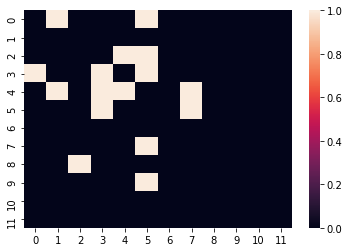

tau 0.0500 mu 0 i 9 j 5
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.025 P3[mu] 0.22499999999999998 P4[mu][i] 0.025
X[i,j] 0.0


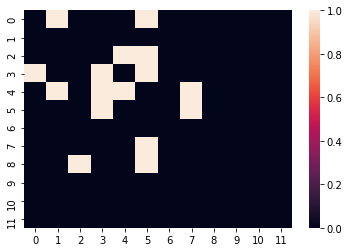

tau 0.0101 mu 2 i 4 j 3
X[i,j] 1.0 X[i - 1,j] 1.0 X[i + 1,j] 1.0 X[i,j - 1] 0.0 X[i,j + 1] 1.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02631578947368421 P3[mu] 0.2894736842105263 P4[mu][i] 0.07894736842105263
X[i,j] 0.0


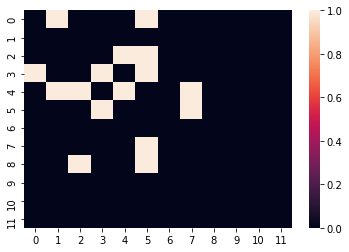

tau 0.0784 mu 3 i 4 j 4
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.023809523809523808 P3[mu] 0.26190476190476186 P4[mu][i] 0.07142857142857142
X[i,j] 0.0


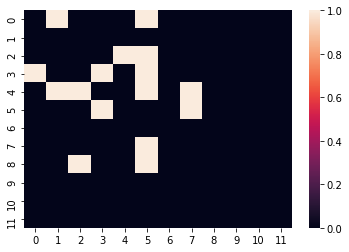

tau 0.0663 mu 1 i 4 j 1
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 1.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.025 P3[mu] 0.22499999999999998 P4[mu][i] 0.07500000000000001
X[i,j] 0.0


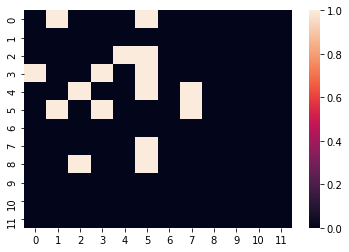

tau 0.0019 mu 1 i 8 j 2
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.023809523809523808 P3[mu] 0.21428571428571427 P4[mu][i] 0.047619047619047616
X[i,j] 0.0


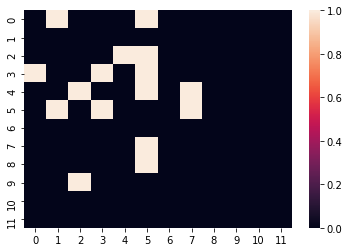

tau 0.0195 mu 1 i 4 j 5
X[i,j] 1.0 X[i - 1,j] 1.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.023809523809523808 P3[mu] 0.21428571428571427 P4[mu][i] 0.047619047619047616
X[i,j] 0.0


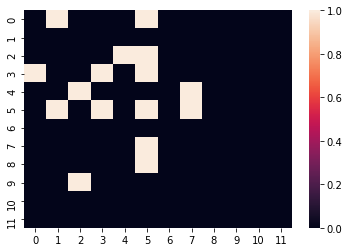

tau 0.0000 mu 2 i 5 j 3
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.022727272727272728 P3[mu] 0.27272727272727276 P4[mu][i] 0.09090909090909091
X[i,j] 0.0


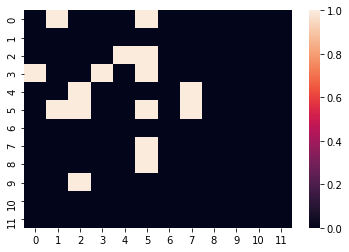

tau 0.1445 mu 0 i 5 j 1
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 1.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.025 P3[mu] 0.22499999999999998 P4[mu][i] 0.05
X[i,j] 0.0


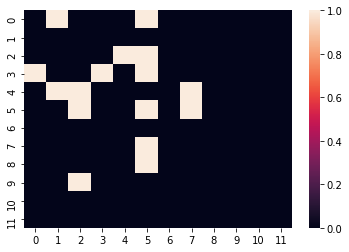

tau 0.0453 mu 2 i 3 j 3
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.025 P3[mu] 0.27499999999999997 P4[mu][i] 0.05
X[i,j] 0.0


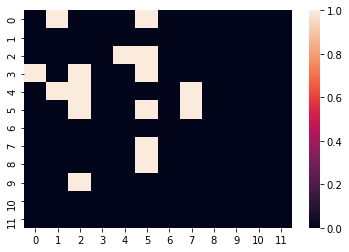

tau 0.0933 mu 3 i 4 j 2
X[i,j] 1.0 X[i - 1,j] 1.0 X[i + 1,j] 1.0 X[i,j - 1] 1.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02631578947368421 P3[mu] 0.2894736842105263 P4[mu][i] 0.05263157894736842
X[i,j] 0.0


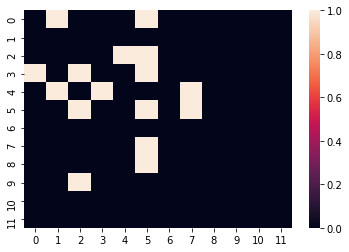

tau 0.0777 mu 1 i 2 j 4
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 1.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.022727272727272728 P3[mu] 0.22727272727272732 P4[mu][i] 0.022727272727272728
X[i,j] 0.0


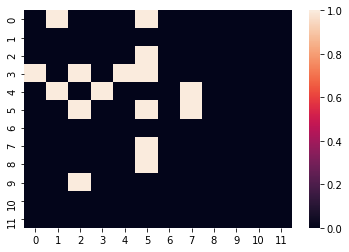

tau 0.0128 mu 2 i 4 j 3
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.022727272727272728 P3[mu] 0.27272727272727276 P4[mu][i] 0.06818181818181818
X[i,j] 0.0


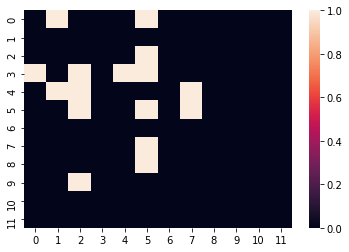

tau 0.0218 mu 3 i 9 j 2
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02631578947368421 P3[mu] 0.2894736842105263 P4[mu][i] 0.02631578947368421
X[i,j] 0.0


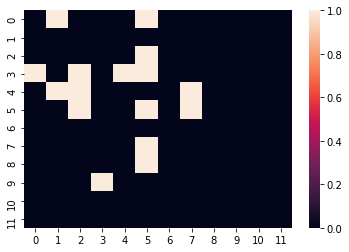

tau 0.0086 mu 3 i 3 j 2
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 1.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02631578947368421 P3[mu] 0.2894736842105263 P4[mu][i] 0.05263157894736842
X[i,j] 0.0


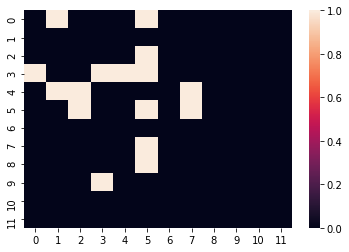

tau 0.0407 mu 2 i 5 j 5
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02631578947368421 P3[mu] 0.2631578947368421 P4[mu][i] 0.07894736842105263
X[i,j] 0.0


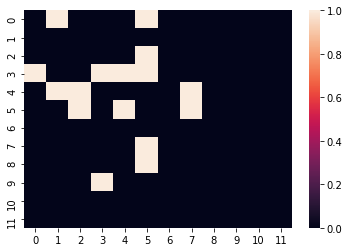

tau 0.0029 mu 1 i 8 j 5
X[i,j] 1.0 X[i - 1,j] 1.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02631578947368421 P3[mu] 0.23684210526315788 P4[mu][i] 0.02631578947368421
X[i,j] 0.0


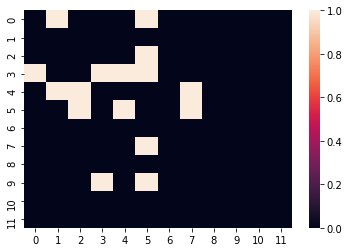

tau 0.0203 mu 1 i 5 j 4
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.025 P3[mu] 0.24999999999999997 P4[mu][i] 0.07500000000000001
X[i,j] 0.0


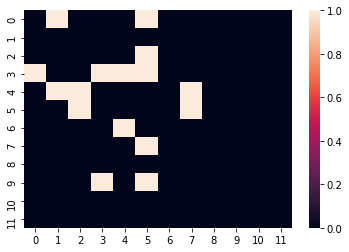

tau 0.0224 mu 3 i 4 j 2
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 1.0 X[i,j - 1] 1.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.025 P3[mu] 0.24999999999999997 P4[mu][i] 0.05
X[i,j] 0.0


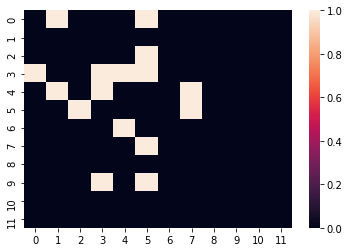

tau 0.0743 mu 1 i 9 j 3
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.023809523809523808 P3[mu] 0.23809523809523808 P4[mu][i] 0.047619047619047616
X[i,j] 0.0


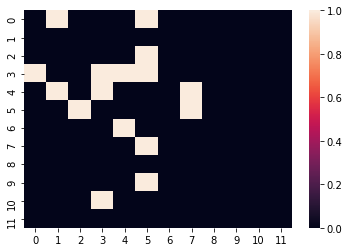

tau 0.0002 mu 0 i 2 j 5
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 1.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.023809523809523808 P3[mu] 0.23809523809523808 P4[mu][i] 0.023809523809523808
X[i,j] 0.0


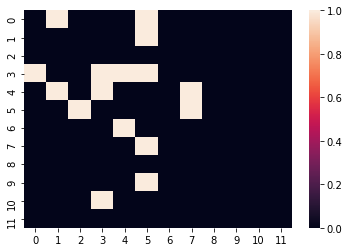

tau 0.0088 mu 2 i 4 j 1
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.023255813953488372 P3[mu] 0.25581395348837205 P4[mu][i] 0.06976744186046512
X[i,j] 0.0


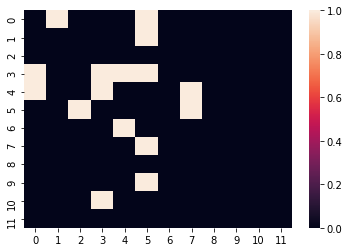

tau 0.0064 mu 0 i 4 j 7
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 1.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02564102564102564 P3[mu] 0.23076923076923073 P4[mu][i] 0.02564102564102564
X[i,j] 0.0


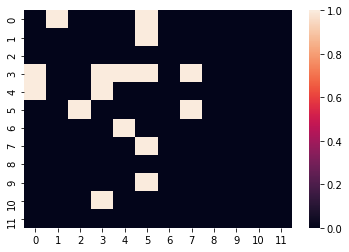

tau 0.0187 mu 3 i 4 j 3
X[i,j] 1.0 X[i - 1,j] 1.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.024390243902439025 P3[mu] 0.2439024390243902 P4[mu][i] 0.024390243902439025
X[i,j] 0.0


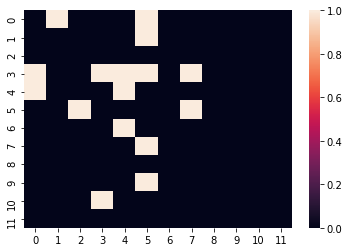

tau 0.0120 mu 3 i 9 j 5
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.024390243902439025 P3[mu] 0.2439024390243902 P4[mu][i] 0.024390243902439025
X[i,j] 0.0


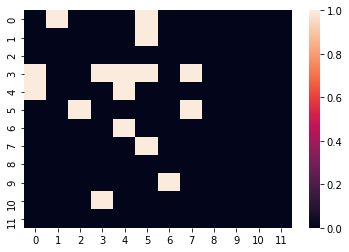

tau 0.0055 mu 2 i 3 j 7
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.024390243902439025 P3[mu] 0.2439024390243902 P4[mu][i] 0.04878048780487805
X[i,j] 0.0


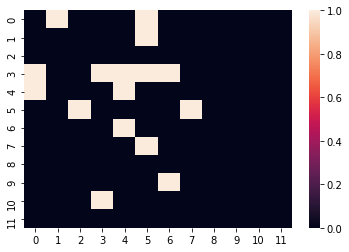

tau 0.0753 mu 1 i 6 j 4
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02564102564102564 P3[mu] 0.28205128205128205 P4[mu][i] 0.02564102564102564
X[i,j] 0.0


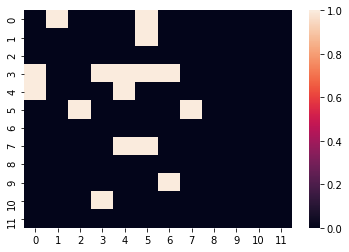

tau 0.0138 mu 2 i 7 j 4
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 1.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02702702702702703 P3[mu] 0.21621621621621623 P4[mu][i] 0.02702702702702703
X[i,j] 0.0


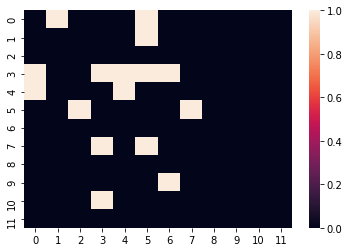

tau 0.0017 mu 1 i 3 j 6
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 1.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02564102564102564 P3[mu] 0.28205128205128205 P4[mu][i] 0.07692307692307693
X[i,j] 0.0


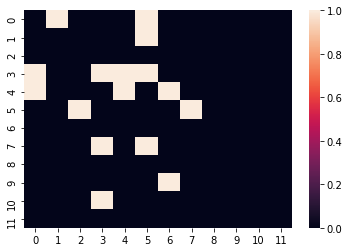

tau 0.0499 mu 2 i 5 j 7
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.024390243902439025 P3[mu] 0.2439024390243902 P4[mu][i] 0.04878048780487805
X[i,j] 0.0


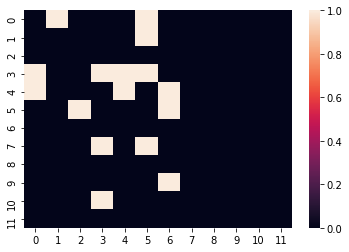

tau 0.0164 mu 2 i 10 j 3
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02564102564102564 P3[mu] 0.2564102564102564 P4[mu][i] 0.02564102564102564
X[i,j] 0.0


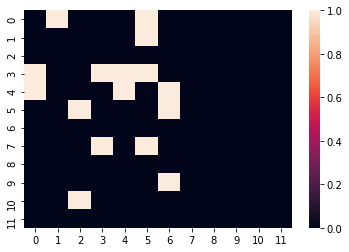

tau 0.0521 mu 1 i 9 j 6
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02564102564102564 P3[mu] 0.2564102564102564 P4[mu][i] 0.02564102564102564
X[i,j] 0.0


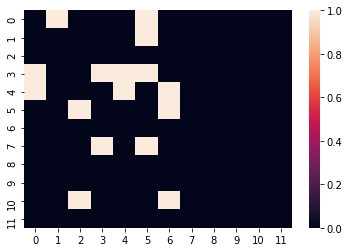

tau 0.0359 mu 1 i 7 j 5
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02564102564102564 P3[mu] 0.2564102564102564 P4[mu][i] 0.05128205128205128
X[i,j] 0.0


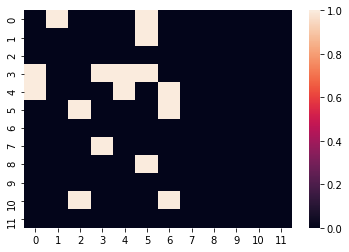

tau 0.0196 mu 2 i 5 j 2
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02564102564102564 P3[mu] 0.2564102564102564 P4[mu][i] 0.05128205128205128
X[i,j] 0.0


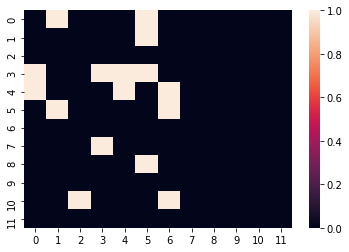

tau 0.0174 mu 2 i 10 j 2
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02564102564102564 P3[mu] 0.2564102564102564 P4[mu][i] 0.05128205128205128
X[i,j] 0.0


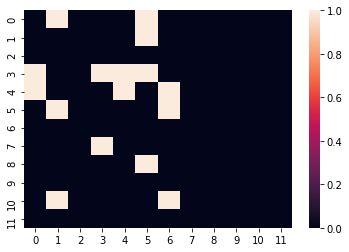

tau 0.0074 mu 0 i 3 j 3
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 1.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02564102564102564 P3[mu] 0.23076923076923073 P4[mu][i] 0.07692307692307693
X[i,j] 0.0


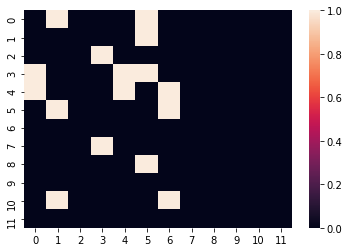

tau 0.0127 mu 1 i 7 j 3
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.024390243902439025 P3[mu] 0.2439024390243902 P4[mu][i] 0.024390243902439025
X[i,j] 0.0


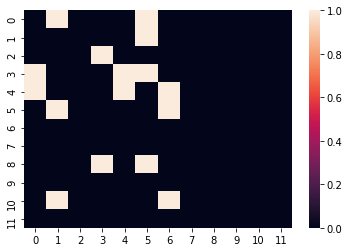

tau 0.0071 mu 3 i 2 j 3
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.024390243902439025 P3[mu] 0.26829268292682923 P4[mu][i] 0.024390243902439025
X[i,j] 0.0


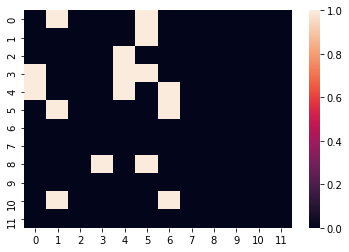

tau 0.0038 mu 3 i 2 j 4
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 1.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02564102564102564 P3[mu] 0.28205128205128205 P4[mu][i] 0.02564102564102564
X[i,j] 0.0


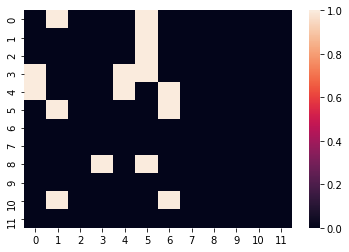

tau 0.0080 mu 0 i 8 j 3
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02702702702702703 P3[mu] 0.1891891891891892 P4[mu][i] 0.05405405405405406
X[i,j] 0.0


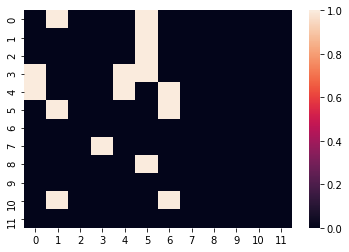

tau 0.0191 mu 0 i 8 j 5
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02702702702702703 P3[mu] 0.1891891891891892 P4[mu][i] 0.02702702702702703
X[i,j] 0.0


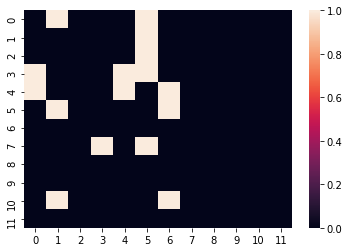

tau 0.0069 mu 3 i 10 j 6
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02702702702702703 P3[mu] 0.2972972972972973 P4[mu][i] 0.05405405405405406
X[i,j] 0.0


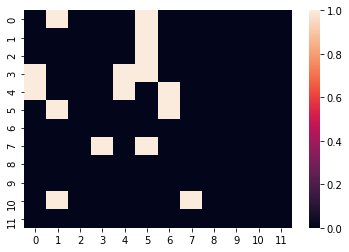

tau 0.0372 mu 2 i 10 j 1
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02702702702702703 P3[mu] 0.2972972972972973 P4[mu][i] 0.05405405405405406
X[i,j] 0.0


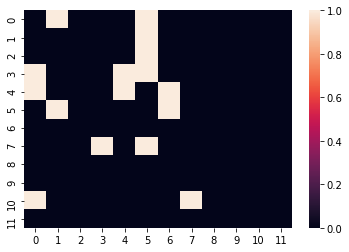

tau 0.0106 mu 1 i 7 j 5
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.030303030303030304 P3[mu] 0.21212121212121213 P4[mu][i] 0.06060606060606061
X[i,j] 0.0


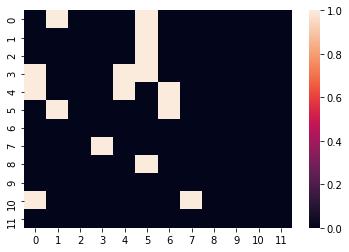

tau 0.0060 mu 1 i 5 j 6
X[i,j] 1.0 X[i - 1,j] 1.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.030303030303030304 P3[mu] 0.21212121212121213 P4[mu][i] 0.06060606060606061
X[i,j] 0.0


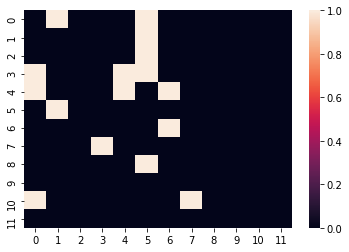

tau 0.0022 mu 1 i 3 j 5
X[i,j] 1.0 X[i - 1,j] 1.0 X[i + 1,j] 0.0 X[i,j - 1] 1.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02857142857142857 P3[mu] 0.2285714285714286 P4[mu][i] 0.02857142857142857
X[i,j] 0.0


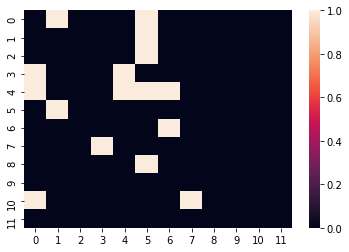

tau 0.0532 mu 2 i 1 j 5
X[i,j] 1.0 X[i - 1,j] 1.0 X[i + 1,j] 1.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02857142857142857 P3[mu] 0.2571428571428572 P4[mu][i] 0.02857142857142857
X[i,j] 0.0


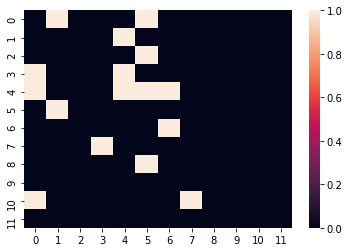

tau 0.0079 mu 0 i 10 j 7
X[i,j] 1.0 X[i - 1,j] 0.0 X[i + 1,j] 0.0 X[i,j - 1] 0.0 X[i,j + 1] 0.0 a(mu,i,j) 1.0 P2[mu][i][j] 0.02631578947368421 P3[mu] 0.2631578947368421 P4[mu][i] 0.02631578947368421
X[i,j] 0.0


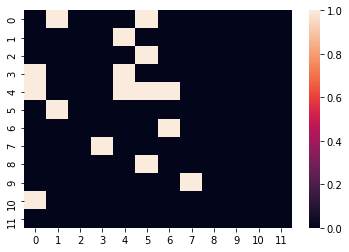

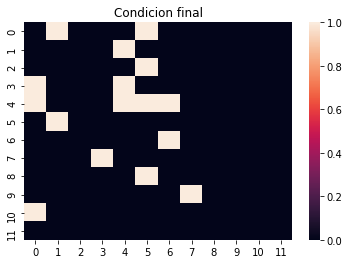

- 0.7998584985733033 minutos de simulación -


In [1002]:
start_time = time.time()

N_pasos = 100


d = 10

# Creamos una condicion inicial; una distribucion de particulas inicial

X0 = np.zeros((d + 2, d + 2))

for i in range(2,6):
    for j in range(2,6):
        X0[i][j] = 1


# Replicamos las condiciones iniciales en el borde

X0 = func_act_CC(X0, d)

# Visualizamos la conddicion inicial

sns.heatmap(X0)
plt.title("Condicion inicial")
plt.show()

# Iniciamos los vetores para las propensiones y probabilidades condicionadas

a = np.zeros((4,102,102))
P2 = np.zeros((4,102,102))
P3 = np.zeros((4))
P4 = np.zeros((102))
#P5 = np.zeros((4,102))

# Iniciamos el tiempo

t = 0

# Calculamos las propensiones

a = actualizacion_as(a,X0, d)

# Lista para registrar los momentos de actualizacion

tiempos = [0]

# Calculo de las probabilidades iniciales

P2, P3 = act_probs(a,a0,P2,P3, d)


# Bucle Principal Monte Carlo

for i in range(0,N_pasos):
    t, X0, a, P2, P3 = paso_montecarlo(X0, a, t, P2, P3, d)
    tiempos.append(t)
    sns.heatmap(X0)
    plt.show()
    
sns.heatmap(X0)
plt.title("Condicion final")
plt.show()

tiempo_Sim = (time.time() - start_time)/60.

print("- %s minutos de simulación -" % (tiempo_Sim))

### Una reverenda mamada que haya cantidades negativas!!!!

Observaciones:
 - Está eligiendo regiones donde no hay partículas
 - Sin embargo, esto no tiene que ver con el cálculo de las $a(\mu,i,j)$, puesto que éstas son nulas en estos puntos
 - Todo indica que se debe a cómo se elige el punto donde se actualizan o el proceso, está eligiendo procesos de probabilidad nula!
 - Tiene que ser con la función que regresa las $mu$, $i$'s y $j$'s!!!
 - Otra pendajada inadmisible es que se pueden acumular particulas en una celda que superen la mayor concentracion máxima inicial!!!

In [902]:
tiempos

[0,
 0.022782939057878905,
 0.02610734412882857,
 0.048790656058410486,
 0.05771995365733049,
 0.05995416170285268,
 0.07688927362413511,
 0.09792596082899703,
 0.10064685583037497,
 0.10404976320464035,
 0.11157473891397447,
 0.11502195889833153,
 0.1197911972663537,
 0.12623550920730012,
 0.1297562360642434,
 0.13139343479445117,
 0.134924822172062,
 0.135850289238767,
 0.1359292925957475,
 0.1390414233509816,
 0.14343814691700968,
 0.14419596259873646,
 0.14493522209833276,
 0.14637190048680093,
 0.15072595141180445,
 0.1555651467744636,
 0.15729701225676557,
 0.1577887476805447,
 0.1585282839226886,
 0.1671757133157456,
 0.17313668989253111,
 0.1788557922846567,
 0.18104822388124395,
 0.18634442204578164,
 0.1933080349416896,
 0.19494516780948318,
 0.19573634084666922,
 0.19602582663045978,
 0.19953661279231316,
 0.21106746884781957,
 0.21500883291801848,
 0.21805031390903748,
 0.22207368125837582,
 0.24101787380098796,
 0.2412863888742947,
 0.24533605437751957,
 0.2544760208826429

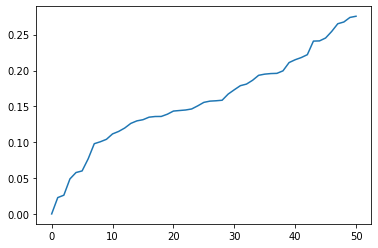

In [903]:
plt.plot(tiempos)

### Pruebas

In [346]:
def actualizacion_as(a, X):
    for i in range(1,101):
        for j in range(1,101):
            a[0][i][j] =  D*(X[i][j] - X[i - 1][j])
            if a[0][i][j] < 0:
                a[0][i][j] = 0
            a[1][i][j] =  D*(X[i][j] - X[i + 1][j])
            if a[1][i][j] < 0:
                a[1][i][j] = 0
            a[2][i][j] =  D*(X[i][j] - X[i][j - 1])
            if a[2][i][j] < 0:
                a[2][i][j] = 0
            a[3][i][j] =  D*(X[i][j] - X[i - 1][j + 1])
            if a[3][i][j] < 0:
                a[3][i][j] = 0
            print(i,j)
    return a

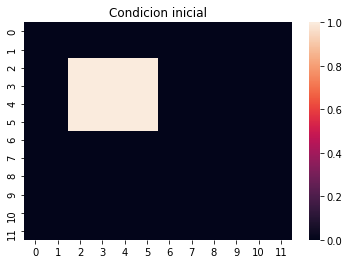

In [973]:
N_pasos = 20


d = 10

# Creamos una condicion inicial; una distribucion de particulas inicial

X0 = np.zeros((d + 2, d + 2))

for i in range(2,6):
    for j in range(2,6):
        X0[i][j] = 1


# Replicamos las condiciones iniciales en el borde

X0 = func_act_CC(X0, d)

# Visualizamos la conddicion inicial

sns.heatmap(X0)
plt.title("Condicion inicial")
plt.show()


In [972]:
X[0][0]

0.0